# Problem set 2 - Monte Carlo method & TD learning

**Due: 11:59pm, October 10, 2025**

### Problem 1 - Monte Carlo evaluation and Monte Carlo control (Coding).

TODO list:

- (1) Finish MC Policy Evaluation Code (10 pt)
- (2) Try different step size and discuss (10 pt)
- (3) Finish MC + Exploring Starts Code (10 pt)
- (4) Plot the convergence behavior, discuss the plot (10 pt)
- (5) Proof of Monte-Carlo control on *random walk* problem (20 pt)
- (6) Finish MC + epsilon greedy Code (10 pt)


<!-- - MC Policy Evaluation Code (long runtime)
- MC Policy Evaluation Different Step size plot
- MC + Exploring Starts Code (long run time)
- MC + ES Observe Plot, describe observation
- MC + ES proof 
- MC + epsilon greedy code  -->

### Problem 2 - Temporal-difference evaluation, SARSA and Q-learning
- (1) Finish TD evaluation Code (10 pt)
- (2) Finish SARSA algorithm (10 pt)
- (3) Finish Q-learning algorithm (10 pt)


<!-- - TD Evaluation
- SARSA
- Q-Learning -->


## Problem 1: Monte-Carlo method on CliffWalk environment.

Recall from last PSET, the **CliffWalking** gridworld is a 4×12 grid. The agent starts at the bottom-left cell and aims to reach the bottom-right. The bottom row between start and goal is a **cliff**; stepping into it ends the episode with a large penalty. Each non-terminal step yields −1; stepping into the cliff yields −100 (and termination).  

In this problem we will **directly use Gym/Gymnasium** to interact with the environment (`CliffWalking-v1`) and perform **Monte-Carlo (MC) method**. Here we provide the print utility function as the same in PSET 1.


In [5]:
import numpy as np
import random
import gymnasium as gym
from tqdm import tqdm
import matplotlib.pyplot as plt

# ----- Reproducibility -----
seed = 0
np.random.seed(seed)          # numpy RNG (env seeding can be done at reset time)

# ----- Environment -----
env = gym.make("CliffWalking-v1")  # 4x12 grid; bottom row is cliff + goal

# Pretty printing for small numeric tables
np.set_printoptions(precision=3, suppress=True)

def print_values(values, nrow: int, ncol: int, title: str = "State Values"):
    """
    Print a value table V in grid form.
    """
    values = np.asarray(values).reshape(nrow, ncol)
    print(title)
    for r in range(nrow):
        print(" ".join(f"{values[r, c]:6.2f}" for c in range(ncol)))
    print()

def print_policy(pi, nrow: int, ncol: int, title: str = "Policy"):
    """
    Render a policy on the CliffWalking grid as arrows.

    The environment uses the action indexing:
        0 = UP, 1 = RIGHT, 2 = DOWN, 3 = LEFT
    """
    arrow = {0: "^", 1: ">", 2: "v", 3: "<"}  # matches env action semantics
    print(title)
    for i in range(nrow):
        row_syms = []
        for j in range(ncol):
            s = i * ncol + j
            p = pi[s]

            # Determine greedy action(s)
            if isinstance(p, list) and len(p) == 4:
                best = np.argwhere(np.array(p) == np.max(p)).flatten().tolist()
            elif isinstance(p, int):
                best = [p]
            else:
                arr = np.array(p, dtype=float).ravel()
                best = np.argwhere(arr == np.max(arr)).flatten().tolist()

            # Cliff/goal cells (bottom row except column 0) rendered as terminal
            if i == nrow - 1 and j > 0:
                row_syms.append("T")
            else:
                row_syms.append("".join(arrow[a] for a in best))
        print(" ".join(sym if sym else "." for sym in row_syms))
    print()

# ----- Reference table (ground-truth under random policy from PSET1) -----
# Shape is (4, 12) in row-major order, then flattened to 1D for convenience.
# Values correspond to the state-value function V^π for the UNIFORM RANDOM policy.
V_random_gt = np.array([
    [-143.21, -147.36, -151.35, -153.93, -155.11, -155.05, -153.66, -150.44, -144.43, -134.39, -119.88, -105.06],
    [-164.99, -174.34, -180.41, -183.52, -184.80, -184.82, -183.62, -180.68, -174.67, -162.95, -141.20, -108.16],
    [-207.96, -237.09, -246.20, -249.36, -250.43, -250.52, -249.79, -247.81, -243.17, -231.62, -199.35,  -96.76],
    [-261.35,    0.00,    0.00,    0.00,    0.00,    0.00,    0.00,    0.00,    0.00,    0.00,    0.00,    0.00],
], dtype=float).flatten()


### 1.1 Monte-Carlo evaluation

Let $\mathcal{D}(s)$ denote the set of all time indices at which state $s$ is visited across sampled episodes. Then the Monte Carlo estimate of the value function is
$$
\hat{V}(s)=\frac{1}{|\mathcal{D}(s)|}\sum_{t\in \mathcal{D}(s)} g_t .
\tag{2.3}
$$

There are two common variants:

- **First-visit MC:** use only the first occurrence of $s$ in each episode.
- **Every-visit MC:** use all occurrences of $s$ within an episode.

You can test both of them in 1.2. For 1.1 you need to finish the **first-visit** one.

**TODO: Finish the code block for monte-carlo evaluation.**


MC first-visit: 100%|██████████| 1000/1000 [01:18<00:00, 12.67it/s]

Estimated State Values (MC First-Visit)
-142.69 -147.01 -151.01 -149.86 -154.96 -151.99 -152.21 -151.13 -146.75 -134.87 -120.19 -108.12
-166.39 -176.95 -174.79 -178.58 -181.48 -184.75 -181.49 -184.50 -179.36 -167.76 -138.96 -105.86
-211.02 -237.22 -247.08 -240.23 -245.01 -254.94 -247.99 -247.97 -245.29 -227.58 -189.79 -94.46
-266.64   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00



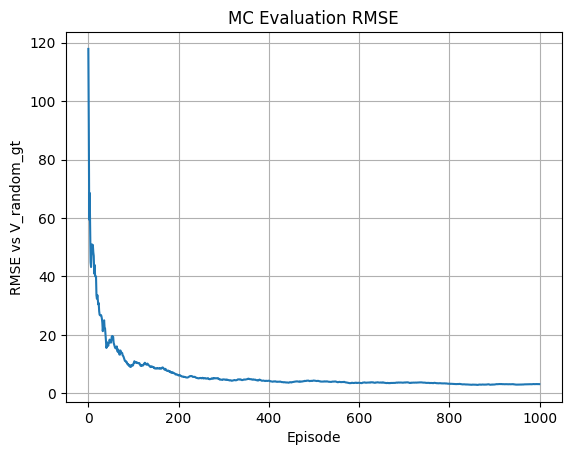

In [ ]:
def mc_evaluate(policy, env, episodes=5000, gamma=0.95, seed=None):
    """
    First-visit Monte Carlo (MC) state-value prediction (Sutton & Barto, Alg. 5.1).

    Parameters
    ----------
    policy : ndarray, shape (nS, nA)
        Row-stochastic policy: for each state s, policy[s] is a prob. dist. over actions.
    env : Gymnasium-like environment
        Must expose discrete observation_space.n and action_space.n and return
        (obs, reward, terminated, truncated, info) from step().
    episodes : int
        Number of episodes to sample.
    gamma : float
        Discount factor in [0, 1].
    seed : int | None
        If given, used to seed a NumPy RNG and (re)seed env at each episode start.
    """
    nS, nA = env.observation_space.n, env.action_space.n
    V = np.zeros(nS, dtype=float)          # value estimates
    N_first = np.zeros(nS, dtype=int)      # first-visit counts per state
    visits = np.zeros(nS, dtype=int)       # total visits (diagnostic only)
    errors = []

    rng = np.random.default_rng(seed)

    for ep in tqdm(range(episodes), desc="MC first-visit"):
        # Episode generation under π
        s, _ = env.reset(seed=int(rng.integers(1e9)) if seed is not None else None)
        states, rewards = [], []
        done = False

        while not done:
            a = rng.choice(nA, p=policy[s])  # sample action from policy
            s_next, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated

            states.append(s)
            rewards.append(r)
            visits[s] += 1

            s = s_next

        # Identify first visits of each state in this episode
        first_visit_mask = [False] * len(states)
        seen_from_start = set()
        for t, st in enumerate(states):
            if st not in seen_from_start:
                seen_from_start.add(st)
                first_visit_mask[t] = True

        # Backward return accumulation; update ONLY on first visits
        G = 0.0
        for t in reversed(range(len(states))):
            s = states[t]
            r = rewards[t]
            G = r + gamma * G

            if first_visit_mask[t]:
                N_first[s] += 1
                V[s] += (G - V[s]) / N_first[s]

        # Track RMSE to a reference table for the random policy (from PSET1)
        rmse = float(np.sqrt(np.mean((V - V_random_gt) ** 2)))
        errors.append(rmse)

    return V, errors


# Uniform-random policy for evaluation
policy = np.ones((env.observation_space.n, env.action_space.n)) / env.action_space.n

V, errors = mc_evaluate(policy, env, episodes=1000)

print_values(V, 4, 12, "Estimated State Values (MC First-Visit)")
# Compare visually with PSET1 reference; they should be close (up to sampling noise).

plt.figure()
plt.plot(errors)
plt.xlabel("Episode")
plt.ylabel("RMSE vs V_random_gt")
plt.title("MC Evaluation RMSE")
plt.grid(True)
plt.show()

# Note: On my laptop this may take ~1 minute for 1k episodes, depending on Python + Gym versions.

### 1.2 Plot for different step size.

Recall equation (2.4) in the lecture note:
$$
\hat{V}(s) \leftarrow \hat{V}(s) + \alpha_{N(s)}\!\left(g_t - \hat{V}(s)\right),
\qquad \alpha_{N(s)} > 0 \text{ diminishing.}
$$

For standard Monte-Carlo evaluation, you will take the $\alpha_{N(s)}$ as $\frac{1}{N(s)}$. But you have more options: you can do constant step or other steps you prefer.

**TODO: test different step size options (sample average, constant step size with different values, and another step size schedule that satisfies Robbins-Monro), and you can also change first-visit to every-visit. What do you observe?**

Hint: you can try save different loss curves and plot in the same plot

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# --- helpers for Gym/Gymnasium compatibility ---
def _safe_reset(env, rng=None, seed=None):
    seed_val = int(rng.integers(1_000_000_000)) if (seed is not None and rng is not None) else None
    out = env.reset(seed=seed_val) if seed_val is not None else env.reset()
    return out[0] if isinstance(out, tuple) else out

def _safe_step(env, a):
    out = env.step(a)
    if len(out) == 5:  # Gymnasium
        obs, r, terminated, truncated, _ = out
        return obs, r, bool(terminated or truncated)
    else:              # Gym
        obs, r, done, _ = out
        return obs, r, bool(done)

def _row_stochastic(policy):
    P = np.array(policy, dtype=float, copy=True)
    P[~np.isfinite(P)] = 0.0
    P = np.clip(P, 0, None)
    rs = P.sum(axis=1, keepdims=True)
    bad = (rs.squeeze() == 0)
    if np.any(bad):
        P[bad] = 1.0 / P.shape[1]
        rs = P.sum(axis=1, keepdims=True)
    return P / rs

# --- generalized MC evaluator ---
def mc_evaluate(
    policy, env, episodes=5000, gamma=0.95, seed=None,
    visit_type="first",                 # "first" or "every"
    stepsize="sample_average",          # "sample_average" | "constant" | "robbins_monro"
    alpha=0.1,                          # used for "constant"
    rm_offset=10.0,                     # c in α_t = 1/(c + n) for Robbins–Monro
    V_init=None, V_ref=None             # V_ref optional (for RMSE curve)
):
    if not hasattr(env.observation_space, "n") or not hasattr(env.action_space, "n"):
        raise TypeError("This evaluator expects Discrete observation/action spaces with `.n`.")
    nS, nA = env.observation_space.n, env.action_space.n

    P = _row_stochastic(policy)
    if P.shape != (nS, nA):
        raise ValueError(f"policy shape {P.shape} != ({nS}, {nA})")

    V = np.zeros(nS) if V_init is None else np.array(V_init, dtype=float)
    updates = np.zeros(nS, dtype=int)   # counts VALUE updates per state
    errors = []

    rng = np.random.default_rng(seed)

    for _ in tqdm(range(episodes), desc=f"MC ({visit_type}-visit, {stepsize})"):
        s = int(_safe_reset(env, rng=rng, seed=seed))
        traj_s, traj_r = [], []
        done = False
        while not done:
            a = int(rng.choice(nA, p=P[s]))
            s_next, r, done = _safe_step(env, a)
            traj_s.append(s)
            traj_r.append(float(r))
            s = int(s_next)

        T = len(traj_s)
        if T == 0:
            if V_ref is not None:
                errors.append(float(np.sqrt(np.mean((V - V_ref) ** 2))))
            continue

        if visit_type == "first":
            first_mask = [False]*T
            seen = set()
            for t, st in enumerate(traj_s):
                if st not in seen:
                    seen.add(st); first_mask[t] = True

        G = 0.0
        for t in reversed(range(T)):
            st = traj_s[t]
            G = traj_r[t] + gamma * G
            if visit_type == "every" or first_mask[t]:
                updates[st] += 1
                if stepsize == "sample_average":
                    alpha_t = 1.0 / updates[st]
                elif stepsize == "constant":
                    alpha_t = float(alpha)
                elif stepsize == "robbins_monro":
                    alpha_t = 1.0 / (rm_offset + updates[st])  # ∑α=∞, ∑α²<∞
                else:
                    raise ValueError(f"Unknown stepsize: {stepsize}")
                V[st] += alpha_t * (G - V[st])

        if V_ref is not None:
            errors.append(float(np.sqrt(np.mean((V - V_ref) ** 2))))

    return V, errors

# --- quick experiment runner to overlay curves ---
def run_step_size_experiment(
    env, policy, V_ref=None, episodes=2000, gamma=0.95, seed=0,
    alphas=(0.02, 0.05, 0.1), rm_offsets=(5.0, 10.0, 25.0),
    visit_types=("first","every")
):
    cfgs = []
    for vt in visit_types:
        cfgs.append((f"{vt} / sample-avg", dict(visit_type=vt, stepsize="sample_average")))
        for a in alphas:
            cfgs.append((f"{vt} / const α={a}", dict(visit_type=vt, stepsize="constant", alpha=a)))
        for c in rm_offsets:
            cfgs.append((f"{vt} / Robbins–Monro c={c}", dict(visit_type=vt, stepsize="robbins_monro", rm_offset=c)))

    curves, finals = [], []
    for label, kw in cfgs:
        V, errs = mc_evaluate(policy, env, episodes=episodes, gamma=gamma, seed=seed, V_ref=V_ref, **kw)
        curves.append((label, errs))
        finals.append((label, V))

    # Plot all RMSE curves (only if V_ref provided)
    if V_ref is not None:
        plt.figure()
        for label, errs in curves:
            if len(errs)>0:
                plt.plot(errs, label=label)
        plt.xlabel("Episode"); plt.ylabel("RMSE vs reference")
        plt.title("MC Evaluation — step size × visit type")
        plt.grid(True); plt.legend(ncol=2, fontsize=8)
        plt.show()

    return finals, curves


MC (every-visit, robbins_monro): 100%|██████████| 1000/1000 [01:20<00:00, 12.45it/s]


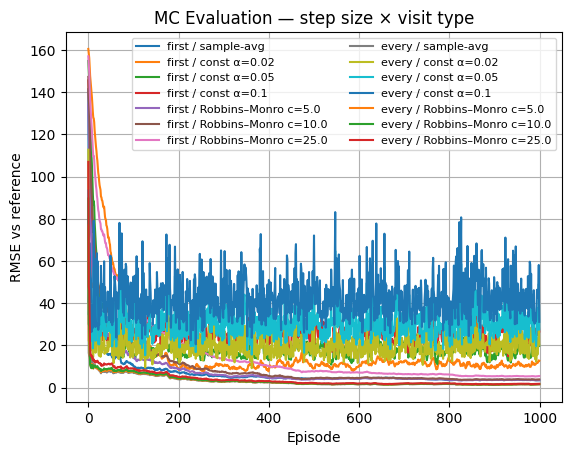

In [16]:
# Uniform random policy (your line)
policy = np.ones((env.observation_space.n, env.action_space.n)) / env.action_space.n

# Optional: if you have a ground-truth vector for the same policy
V_ref = V_random_gt  # or None if you don't have it

# Single run (e.g., every-visit, constant α=0.1)
V_ev_const, errs = mc_evaluate(
    policy, env, episodes=1000, gamma=0.95, seed=0,
    visit_type="every", stepsize="constant", alpha=0.1, V_ref=V_ref
)

# Overlay multiple curves in one figure
finals, curves = run_step_size_experiment(
    env, policy, V_ref=V_ref, episodes=1000, gamma=0.95, seed=0,
    alphas=(0.02, 0.05, 0.1), rm_offsets=(5.0, 10.0, 25.0),
    visit_types=("first","every")
)


### 1.3 Monte-Carlo control with Exploring Starts

In the class we talk about two methods to ensure exploration: exploring starts and $\epsilon$-greedy policy. We will start with exploring starts for monte-carlo control.

**TODO: finish code of Monte-Carlo control with exploring starts**.

In [9]:
def _set_state(env, s):
    """Attempt to set the environment's internal discrete state to `s`
    (needed for Exploring Starts).
    """
    try:
        # Many classic-control/grid envs expose `unwrapped.s`
        env.unwrapped.s = s
        return True
    except Exception:
        # Some variants use `.state` instead
        try:
            env.unwrapped.state = s
            return True
        except Exception:
            return False


def mc_control_exploring_starts(env, episodes=5000, gamma=0.95, max_steps=500, alpha=None):
    """
    Monte Carlo control with Exploring Starts (ES).  See Sutton & Barto, Alg. 5.3.

    Procedure
    ---------
    1) For each episode, sample an initial state–action pair (S0, A0) at random so that
       every (s, a) has nonzero probability.
    2) Roll out the *entire* episode under the current policy π (use A0 at t=0; thereafter
       sample actions from π).
    3) At the end of the episode, perform **first-visit** MC updates to Q(s, a) using the
       return G from each first-visited (s, a).
    4) For all states visited in this episode, improve the policy greedily:
       π(s) ← argmax_a Q(s, a) (break ties uniformly).
    """
    nS, nA = env.observation_space.n, env.action_space.n
    Q = np.zeros((nS, nA), dtype=float)
    N_visits = np.zeros((nS, nA), dtype=int)
    V_snaps = []

    # Initialize π arbitrarily: start with a uniform distribution over actions.
    policy = np.ones((nS, nA), dtype=float) / nA

    for ep in tqdm(range(episodes), desc="MC ES (Exploring Starts)"):
        # --- Exploring Start: choose (S0, A0) uniformly at random ---
        # For CliffWalking we avoid terminal/cliff cells by excluding the last row
        # except the start (index 36). `nS - 11` ensures s0 ∈ {0..36}.
        s0 = np.random.randint(nS - 11)
        a0 = np.random.randint(nA)

        # Reset env, then force the start state to s0. If not supported, ES cannot be run strictly.
        s, _ = env.reset()
        if not _set_state(env, s0):
            raise RuntimeError(
                "Environment does not support setting arbitrary start states; "
                "strict Exploring Starts is not possible."
            )

        # --- Generate a full trajectory under current π (A0 at t=0, then follow π) ---
        states, actions, rewards = [], [], []
        s = s0
        a = a0
        done = False

        # Cap length to avoid pathological loops when π does not reach a terminal.
        for _ in range(max_steps):
            states.append(s)
            actions.append(a)

            # take a step
            s_next, r, terminated, truncated, _ = env.step(a)
            rewards.append(r)
            done = terminated or truncated
            if done:
                break
            s = s_next
            a = np.random.choice(nA, p=policy[s])

        # --- First-visit masks for (s, a) within this episode ---
        first_visit_sa_mask = [False] * len(states)
        seen_from_start_sa = set()
        for t, (st, at) in enumerate(zip(states, actions)):
            if (st, at) not in seen_from_start_sa:
                seen_from_start_sa.add((st, at))
                first_visit_sa_mask[t] = True

        # --- Backward return accumulation; update Q only at first visits ---
        G = 0.0
        for t in reversed(range(len(states))):
            G = gamma * G + rewards[t]
            if first_visit_sa_mask[t]:
                st, at = states[t], actions[t]
                N_visits[st, at] += 1
                if alpha is None:
                    # incremental average over first visits
                    Q[st, at] += (G - Q[st, at]) / N_visits[st, at]
                else:
                    # constant-step-size update
                    Q[st, at] += alpha * (G - Q[st, at])

        visited_states = set(states)
        for st in visited_states:
            best_actions = np.flatnonzero(Q[st] == Q[st].max())
            policy[st] = 0.0
            policy[st, best_actions] = 1.0 / len(best_actions)

        # Keep a few early snapshots of V(s) for quick diagnostics
        if (ep % 100) == 0 and ep <= 10000:
            V = Q.max(axis=1)
            V_snaps.append(V.copy())

    return policy, Q, V_snaps


policy_es, Q_es, V_snaps = mc_control_exploring_starts(env, episodes=200000, gamma=0.95)

V_es = (policy_es * Q_es).sum(axis=1)
print_values(V_es, 4, 12, "V from MC-ES policy")
print_policy(policy_es, 4, 12, "MC-ES derived policy")

# Note: With 200k episodes this can take around a minute on a typical laptop
# (depends on Python/Gym versions and hardware).


MC ES (Exploring Starts): 100%|██████████| 200000/200000 [00:46<00:00, 4314.56it/s]

V from MC-ES policy
-10.37  -9.86  -9.27  -8.64  -8.08  -7.43  -6.74  -6.06  -5.31  -4.54  -3.71  -2.90
 -9.78  -9.22  -8.66  -8.12  -7.43  -6.74  -6.03  -5.30  -4.53  -3.71  -2.85  -1.95
 -9.22  -8.64  -8.05  -7.42  -6.76  -6.03  -5.30  -4.53  -3.71  -2.85  -1.95  -1.00
 -9.78   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00

MC-ES derived policy
v > > v > > v > v v v v
> > > v > > > v > > v v
> > > > > > > > > > > v
^ T T T T T T T T T T T



### 1.4 Convergence behavior

Use the `V_snap` you get from Monte-Carlo control to plot the convergence evolution.

States close to the terminal stabilize quickly because their returns are less noisy and episodes frequently pass through them once the policy starts improving.

Hint: which part converge first?

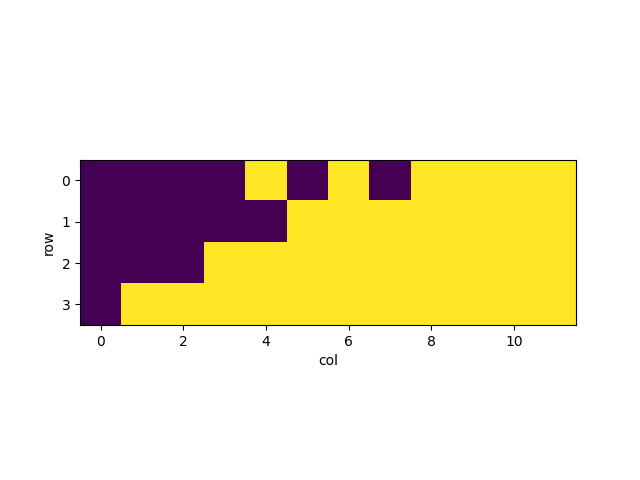

Saved GIF to: ./mc_es_grid_evolution.gif


In [12]:
import matplotlib.animation as animation
from IPython.display import Image, display

# Basic check
V_snaps = [np.asarray(v).ravel() for v in V_snaps]
K = int(V_snaps[0].size)
if K != 48:
    raise ValueError(f"Expected V.size == 48 to reshape into 4x12, but got {K}.")

# Fixed color scale to avoid per-frame jumps (do not specify a colormap; use defaults)
V_all = np.vstack(V_snaps)
vmin, vmax = -20, 0

# Initialize figure: 2D grid
fig, ax = plt.subplots()
grid0 = V_snaps[0].reshape(4, 12)
im = ax.imshow(grid0, vmin=vmin, vmax=vmax)  # Do not specify cmap
ax.set_xlabel("col")
ax.set_ylabel("row")

def init():
    im.set_data(grid0)
    return (im,)  # blit requires a tuple

def update(i):
    grid = V_snaps[i].reshape(4, 12)
    im.set_data(grid)
    return (im,)

ani = animation.FuncAnimation(
    fig, update, frames=len(V_snaps), init_func=init, blit=True, interval=400, repeat=False
)

gif_path = "./mc_es_grid_evolution.gif"
ani.save(gif_path, writer="pillow")
plt.close(fig)

display(Image(filename=gif_path))
print("Saved GIF to:", gif_path)

# Print the last frame as a 4x12 grid
V_last = V_snaps[-1].reshape(4, 12)
np.set_printoptions(precision=2, suppress=True)  # Pretty printing

### 1.5 Random walk on a ring: Why can monte-carlo method works? (Pen and Paper)

In this problem you will use a random walk problem to analyze the convergence behavior of Monte-Carlo control.

Consider a 1-D random walk problem on a ring, and one of them is the terminal state. Assume states are $\{0,1,2,...,K - 1\}$, and $0$ is the terminal state. The transition model can be written as $x_{k+1} = \text{mod}(x_k + u_k)$ where $u_k = -1 / 1$.

**Setup.**  
States $ \mathcal S=\{0,1,\dots,K-1\} $ with terminal $0$ (absorbing).  
Actions $ \mathcal A=\{-1,+1\} $, transition $ s'=(s+a)\bmod K $ (Note that terminal is absorb, so once it arrive $0$ it will not move).  
Per-step reward $-1$ until termination; discount $ \gamma\in(0,1] $.  
Distance to $0$: $ d(s)=\min\{s,K-s\} $.  
Algorithm: first-visit Monte-Carlo control with **Exploring Starts**.

**Claim.** With probability $1$, the learned policy converges to
$$
\pi^\star(s)=
\begin{cases}
\text{move to reduce } d(s), & d(s)\neq K/2,\\
\text{either action}, & d(s)=K/2 \text{ (if $K$ even),}
\end{cases}
$$
i.e., “go along the shortest arc to $0$”.

### Proof (outward induction on $d$)

First we write down the optimal value $V^\star$ under $\pi^\star$

**(a) TODO: write down $V^\star$** 

**Answer:**
Let $d(s)=\min\{s,\,K-s\}$ be the distance to $0$.
Under $\pi^\star$ you move one step toward $0$ each time, so it takes exactly $d(s)$ steps to terminate, receiving $-1$ per step.

$$
V^\star(s)=
\begin{cases}
0, & s=0,\\[6pt]
-\displaystyle\sum_{t=0}^{d(s)-1}\gamma^{t}
= -\dfrac{1-\gamma^{\,d(s)}}{1-\gamma}, & \gamma\in(0,1),\ s\neq 0,\\[10pt]
-d(s), & \gamma=1,\ s\neq 0~.
\end{cases}
$$

**Base of induction ($d=0$).** 

**(b) TODO: Show that $Q(0,a)\equiv 0$** 

**Answer:** 

By setup, $0$ is terminal (absorbing) and the per-step reward is $-1$ **until termination**. At the terminal state there are no further transitions or rewards.
Therefore the return from $0$ is $G_t = 0$.
Formally, for any policy $\pi$ and any action $a$,
  $$
  Q^\pi(0,a)
  = \mathbb{E}\!\left[\,G_t \mid S_t=0,\; A_t=a\,\right]
  = 0.
  $$
Equivalently, viewing $0$ as an absorbing self-loop with zero reward,
  $$
  Q^\pi(0,a)
  = \mathbb{E}\!\left[\,R_{t+1} + \gamma V^\pi(S_{t+1}) \mid S_t=0,\; A_t=a\,\right]
  = 0 + \gamma \cdot 0 = 0.
  $$

Hence $Q(0,a)=0$ for all $a$.

**Inductive hypothesis.** For every state with $d\le m-1$, the maximization of $Q(s,a)$ is already optimal, i.e.
$$
\max_a Q(s,a) := V(s) = V^\star
$$

**(c) TODO: For $d(s)=m$, show that $Q(s,\text{toward}) \leq Q(s,\text{away})$ (equality hold only when $s = \frac{K}{2}$)** 

**Answer:** 

//

Therefore greedy improvement sets $\pi(s)=\text{toward}$. By convergence of monte-carlo evaluation under fix policy, $Q(s,\text{toward})$ finally converge.

### 1.6 Monte-Carlo control with $\epsilon$-soft policies

**TODO: finish the code for Monte-Carlo control with $\epsilon$-soft policies** 

In [17]:
def _epsilon_soft_from_Q(Q_row: np.ndarray, epsilon: float, tol: float = 1e-12) -> np.ndarray:
    """
    Build an ε-soft *greedy* action distribution from a vector of Q-values.

    Rule:
      1) Give every action a base mass ε/|A|.
      2) Split the remaining (1-ε) uniformly among the greedy (argmax) actions.
         (Deterministic tie-handling: no random tie-breaking.)
    """
    nA = Q_row.shape[0]
    probs = np.full(nA, epsilon / nA, dtype=float)

    m = Q_row.max()
    ties = np.flatnonzero(np.isclose(Q_row, m, atol=tol, rtol=0.0))
    share = (1.0 - epsilon) / ties.size
    probs[ties] += share
    return probs


def mc_control_onpolicy_epsilon_soft(
    env,
    episodes: int = 5000,
    gamma: float = 0.95,
    max_steps: int = 500,
    alpha: float | None = None,   # None → sample mean 1/N(s,a); else constant step-size
    epsilon: float = 0.1,         # constant ε if no schedule is provided
    eps_schedule=None,            # optional callable: eps = eps_schedule(ep)  (GLIE-style)
    min_epsilon: float = 0.0,
):
    """
    On-policy first-visit Monte Carlo control with ε-soft policies
    (Sutton & Barto, On-policy MC Control).

    Key differences from MC with Exploring Starts (ES):
      • No exploring starts; episodes are generated by the current ε-soft policy π.
      • Policy improvement *keeps* π ε-soft: greedy actions get (1-ε)+ε/|A|, others ε/|A|.
    """
    nS = env.observation_space.n
    nA = env.action_space.n

    Q = np.zeros((nS, nA), dtype=float)
    N_first = np.zeros((nS, nA), dtype=int)

    # Initialize π arbitrarily: uniform over actions (already ε-soft for any ε).
    policy = np.full((nS, nA), 1.0 / nA, dtype=float)

    ep_idx, V_snaps = [], []

    for ep in tqdm(range(episodes), desc="MC (ε-soft)"):
        # GLIE-style ε schedule (optional)
        eps = float(eps_schedule(ep)) if eps_schedule is not None else float(epsilon)
        eps = float(np.clip(eps, min_epsilon, 1.0))

        # ---- Generate one episode under current ε-soft policy π ----
        states, actions, rewards = [], [], []
        s, _ = env.reset()
        a = int(np.random.choice(nA, p=policy[s]))  # first action from current policy

        for _ in range(max_steps):
            states.append(s)
            actions.append(a)
            s_next, r, terminated, truncated, _ = env.step(a)
            rewards.append(r)

            if terminated or truncated:
                break

            s = s_next
            a = int(np.random.choice(nA, p=policy[s]))

        # ---- First-visit markers for (s,a) within this episode ----
        seen = set()
        first_visit = [False] * len(states)
        for t, (st, at) in enumerate(zip(states, actions)):
            if (st, at) not in seen:
                seen.add((st, at))
                first_visit[t] = True

        G = 0.0
        for t in range(len(states) - 1, -1, -1):
            G = gamma * G + rewards[t]
            if first_visit[t]:
                st, at = states[t], actions[t]
                N_first[st, at] += 1
                step = (1.0 / N_first[st, at]) if alpha is None else alpha
                Q[st, at] += step * (G - Q[st, at])

        # ---- ε-soft greedy policy improvement (only on states seen this episode) ----
        visited_states = set(states)
        for st in visited_states:
            policy[st] = _epsilon_soft_from_Q(Q[st], eps)

        # Light snapshots for convergence plots (every 100 eps)
        if (ep % 100) == 0:
            V = Q.max(axis=1)
            V_snaps.append(V.copy())

    return policy, Q, V_snaps


def eps_schedule(ep, c=2000.0, eps_min=0.01):
    """Simple GLIE schedule: ε_ep = max(eps_min, c / (c + ep))."""
    return max(eps_min, c / (c + ep))


policy, Q, V_snaps = mc_control_onpolicy_epsilon_soft(
    env,
    episodes=10000,
    gamma=0.95,
    epsilon=1.0,  # start fully exploratory; schedule will decay it
    eps_schedule=lambda ep: eps_schedule(ep, c=2000.0, eps_min=0.01),
    min_epsilon=0.0,
    alpha=0.01    # constant step-size for Q-updates (try None for 1/N(s,a))
)

V_soft = (policy * Q).sum(axis=1)
print_values(V_soft, 4, 12, "V from MC ε-soft policy")
print_policy(policy, 4, 12, "MC ε-soft derived policy")


MC (ε-soft): 100%|██████████| 10000/10000 [00:11<00:00, 894.40it/s]

V from MC ε-soft policy
-12.08 -11.89 -11.35 -10.83 -10.09  -9.48  -8.65  -7.85  -7.01  -6.03  -5.08  -4.14
-12.57 -13.93 -14.71 -15.24 -13.73 -13.62 -12.38 -12.15 -11.31  -8.98  -5.27  -3.14
-13.41 -20.84 -31.12 -42.30 -39.19 -39.31 -39.40 -40.79 -34.75 -24.35 -10.30  -1.58
-18.63   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00

MC ε-soft derived policy
> > > > > > > > > > > v
^ ^ ^ ^ ^ ^ ^ ^ ^ ^ > v
^ ^ ^ ^ ^ ^ ^ ^ ^ ^ > v
^ T T T T T T T T T T T



## Problem 2: SARSA & Q-learning on Cliffwalk environment

### 2.1 TD evaluation

**Algorithmic Form.** Suppose the agent is in state $s_t$, takes action $a_t \sim \pi(\cdot \mid s_t)$, receives reward $r_t$, and transitions to $s_{t+1}$. The TD(0) update rule is
$$
\hat V(s_t) \leftarrow \hat V(s_t) + \alpha\,[\,r_t + \gamma \hat V(s_{t+1}) - \hat V(s_t)\,],
\tag{2.6}
$$
where $\alpha \in (0,1]$ is the learning rate.

The term inside the brackets,
$$
\delta_t = r_t + \gamma \hat V(s_{t+1}) - \hat V(s_t),
\tag{2.7}
$$
is called the **TD error**.

**TODO: finish the code for TD evluation**

TD evaluation: 100%|██████████| 1000/1000 [01:22<00:00, 12.19it/s]

Estimated State Values (TD(0) evaluation)
-143.86 -145.79 -148.06 -152.49 -153.57 -156.54 -154.22 -149.86 -143.86 -133.71 -118.71 -105.14
-164.42 -173.62 -176.79 -177.59 -180.33 -184.60 -182.09 -181.97 -174.19 -160.05 -138.93 -104.37
-202.03 -232.34 -245.22 -243.59 -244.12 -251.37 -250.21 -247.23 -242.56 -226.73 -199.66 -81.22
-257.02   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00



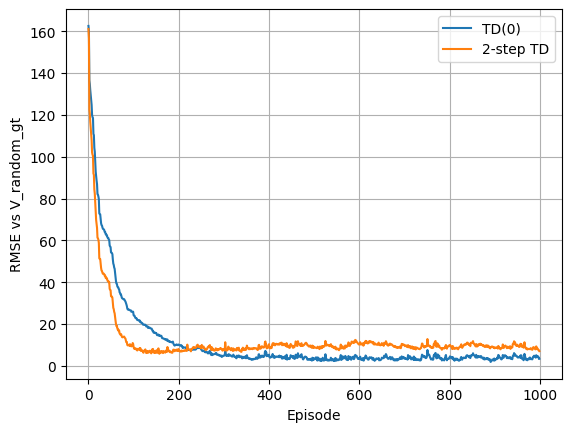

In [18]:
def td0_evaluate(env, episodes=5000, gamma=0.95, alpha=0.1, seed=None):
    """
    On-policy temporal-difference evaluation under a **uniform random policy**.

    Computes:
      • V_TD0 : TD(0) / 1-step bootstrap   V(s_t) ← V(s_t) + α [ r_t + γ V(s_{t+1}) − V(s_t) ]
      • V_TD2 : 2-step TD for the *previous* state s_{t-1}
                V(s_{t-1}) ← V(s_{t-1}) + α [ r_{t-1} + γ r_t + γ^2 V(s_{t+1}) − V(s_{t-1}) ]
                (This is the n=2 special case of n-step TD.)
    Returns V_TD0 and RMSE traces for both estimators vs the provided V_random_gt.
    """
    nS, nA = env.observation_space.n, env.action_space.n
    policy = np.ones((nS, nA)) / nA

    V_TD0 = np.zeros(nS, dtype=float)
    V_TD2 = np.zeros(nS, dtype=float)

    visit_counts = np.zeros(nS, dtype=int)  # diagnostic only
    errors_1, errors_2 = [], []

    if seed is not None:
        np.random.seed(seed)

    for _ in tqdm(range(episodes), desc="TD evaluation"):
        s, _ = env.reset()
        done = False

        # Keep the previous transition to form a 2-step target
        prev_state = None      # will hold s_{t-1}
        prev_reward = None     # will hold r_{t-1}

        while not done:
            # sample action from the uniform random policy and step
            a = int(np.random.choice(nA, p=policy[s]))
            s_next, r, terminated, truncated, _ = env.step(a)
            done = bool(terminated or truncated)

            # TD(0) update for current state s
            v_next = 0.0 if done else V_TD0[s_next]
            V_TD0[s] += alpha * (r + gamma * v_next - V_TD0[s])

            # 2-step TD update for the previous state (if we have one)
            if prev_state is not None:
                v2_next = 0.0 if done else V_TD2[s_next]
                target2 = prev_reward + gamma * r + (gamma**2) * v2_next
                V_TD2[prev_state] += alpha * (target2 - V_TD2[prev_state])

            # diagnostics and shift the window
            visit_counts[s] += 1
            prev_state, prev_reward = s, r
            s = s_next

        # Episode-level RMSE diagnostics
        errors_1.append(np.sqrt(np.mean((V_TD0 - V_random_gt) ** 2)))
        errors_2.append(np.sqrt(np.mean((V_TD2 - V_random_gt) ** 2)))

    return V_TD0, (errors_1, errors_2)


# Example run
V, (errors_1, errors_2) = td0_evaluate(env, episodes=1000, alpha=0.01)

print_values(V, 4, 12, "Estimated State Values (TD(0) evaluation)")

plt.figure()
plt.plot(errors_1, label="TD(0)")
plt.plot(errors_2, label="2-step TD")
plt.xlabel("Episode")
plt.ylabel("RMSE vs V_random_gt")
plt.grid(True)
plt.legend()
plt.show()

# Note: On my laptop this may take ~20s for 1k episodes


### 2.2 SARSA algorithm

In [19]:
def sarsa(
    env,
    episodes=5000,
    Q_init=None,
    gamma=0.95,
    epsilon=0.01,
    alpha=0.1,
    max_steps=500,       # per-episode safety cap
):
    """
    On-policy SARSA(0) control for **tabular, discrete** Gymnasium environments.

    Behavior policy: ε-greedy w.r.t. current Q.
    Update rule (per step):
        Q(s,a) ← Q(s,a) + α [ r + γ Q(s', a') − Q(s,a) ],
    where a' is sampled ε-greedily from state s' (on-policy).
    """
    nS, nA = env.observation_space.n, env.action_space.n
    Q = Q_init.copy() if Q_init is not None else np.zeros((nS, nA), dtype=float)
    visits = np.zeros((nS, nA), dtype=int)
    V_snaps = []

    def eps_greedy_action(s, eps):
        """ε-greedy over Q[s]: uniform random with prob ε; otherwise greedy with random tie-break."""
        if np.random.rand() < eps:
            return np.random.randint(nA)
        row = Q[s]
        m = row.max()
        candidates = np.flatnonzero(row == m)
        return int(np.random.choice(candidates))

    for ep in tqdm(range(episodes), desc="SARSA control"):
        s, _ = env.reset()
        a = eps_greedy_action(s, epsilon)

        # (Optional) record of visited states; useful for debugging/plots.
        s_record = []

        for _ in range(max_steps):
            s_record.append(s)

            # take action a
            s_next, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated

            # choose next action on-policy (ε-greedy), unless episode ended
            if not done:
                a_next = eps_greedy_action(s_next, epsilon)

            # TD target and update
            s_i, a_i = int(s), int(a)
            if done:
                td_target = r
            else:
                td_target = r + gamma * Q[int(s_next), int(a_next)]

            visits[s_i, a_i] += 1
            Q[s_i, a_i] += alpha * (td_target - Q[s_i, a_i])

            # move to next state-action or finish
            if done:
                break
            s, a = s_next, a_next


        # Lightweight snapshots early on (every 2 episodes up to 100)
        if (ep % 2) == 0 and ep <= 100:
            V_snaps.append(Q.max(axis=1).copy())

    return Q, visits, V_snaps


Q, visits, V_snaps = sarsa(env, episodes=50000, gamma=0.95, alpha=0.01, epsilon=0.01)
V = Q.max(axis=1)
print_values(V, 4, 12, title="State Values (greedy after SARSA)")


SARSA control: 100%|██████████| 50000/50000 [00:10<00:00, 4756.37it/s]

State Values (greedy after SARSA)
 -9.50  -9.14  -8.70  -8.20  -7.67  -7.11  -6.50  -5.86  -5.18  -4.45  -3.68  -2.86
 -9.77  -9.23  -8.66  -8.07  -7.43  -6.76  -6.06  -5.31  -4.54  -3.72  -2.86  -1.96
-10.29  -9.67  -8.89  -8.13  -7.33  -6.60  -5.82  -4.84  -4.02  -3.05  -1.95  -1.00
-10.78   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00



### 2.3 Q-learning algorithm

In [20]:
def q_learning(
    env,
    episodes=20000,
    gamma=0.95,
    epsilon=0.01,
    alpha=0.1,
    max_steps=500,       # per-episode safety cap
):
    """
    Tabular **Q-learning** (off-policy, 1-step TD) control.

    Behavior policy: ε-greedy w.r.t. current Q (for exploration).
    Target policy:   greedy (max over actions in s')  — this is what makes it **off-policy**.

    Update (per step):
        Q(s,a) ← Q(s,a) + α [ r + γ * max_{a'} Q(s', a') − Q(s,a) ].
    """
    nS, nA = env.observation_space.n, env.action_space.n
    Q = np.zeros((nS, nA), dtype=float)
    visits = np.zeros((nS, nA), dtype=int)  # diagnostic: how often each (s,a) is updated
    V_snaps = []

    def eps_greedy_action(s, eps):
        """ε-greedy over Q[s]: with prob ε pick random action; else greedy with random tie-break."""
        if np.random.rand() < eps:
            return np.random.randint(nA)
        row = Q[s]
        m = row.max()
        candidates = np.flatnonzero(row == m)  # random tie-breaking argmax
        return int(np.random.choice(candidates))

    for ep in tqdm(range(episodes), desc="Q-learning control"):
        s, _ = env.reset()

        for _ in range(max_steps):
                        # ε-greedy action from current state
            a = eps_greedy_action(s, epsilon)

            # take step
            s_next, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated

            # 1-step Q-learning target (off-policy: greedy in s')
            best_next = 0.0 if done else Q[s_next].max()
            td_target = r + gamma * best_next

            # update
            Q[s, a] += alpha * (td_target - Q[s, a])
            visits[s, a] += 1

            # move to next state (end episode if done)
            s = s_next
            if done:
                break


        # light snapshots early on (every 10 episodes up to 1k)
        if (ep % 10) == 0 and ep <= 1000:
            V_snaps.append(Q.max(axis=1).copy())

    return Q, V_snaps


Q, V_snaps = q_learning(env, episodes=50000, gamma=0.95, alpha=0.01, epsilon=0.01)
V = Q.max(axis=1)
print_values(V, 4, 12, title="State Values (greedy after Q-learning)")


Q-learning control: 100%|██████████| 50000/50000 [00:10<00:00, 4854.22it/s]

State Values (greedy after Q-learning)
 -8.71  -8.43  -8.04  -7.59  -7.10  -6.57  -6.00  -5.40  -4.76  -4.11  -3.43  -2.76
 -8.97  -8.61  -8.17  -7.68  -7.14  -6.55  -5.90  -5.21  -4.47  -3.69  -2.84  -1.95
 -9.19  -8.62  -8.03  -7.40  -6.73  -6.03  -5.30  -4.52  -3.71  -2.85  -1.95  -1.00
 -9.73   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00

